# Self-Driving Cars: Localization
#### James Feng, Andrew Lin, Hao Zhang

## Why do we need self-driving cars?

Growing interest in autonomous transportation for industrial and consumer applications

Benefit:
 - Improve fuel efficiency
 - Reduce emmissions
 - Minimize traffic congestion
 - Increase lane capacity
 - Improve public safety
 - Free up driver's time
 - Reduce insurance rate
 - More accessibility
 - Opportunity for future analytics

<h2><center>Robotics and autonomous vehicles utilize sensors and effectors</center></h2>

<img src="Sense and Action.png" width="400" align="center"/>

There is inaccuracy in all sensors and effectors

Software algorithms are available to ultilize probabilistic modeling to accurately localize position


## 1D Localization

In a simplified world
 - world: 1D environment labeled by red or green color 
      - `world = ['green', 'red', 'red', 'green', 'green']`
 - p: initial probability distribution of the world
      - `p = [0.2, 0.2, 0.2, 0.2, 0.2]`
 - measurements: red/green color reported by the sensor
      - `measurements = ['red', 'red']`
 - motions: movement of the vehicle
      - `motions = [1,1]`
 - sensor accuracy: correct reading on a scale of 0-1
      - `pHit = 0.6`
      - `pMiss = 0.2`
 - motor accuracy: correct movement on a scale of 0-1
      - `pExact = 0.8`
      - `pOvershoot = 0.1`
      - `pUndershoot = 0.1`
    
      
Need two functions: 
```python
def sense(world, p, measurement, pHit, pMiss)
    return post_p
    
def move(world, p, motion, pExact, pOvershoot, pUndershoot)
    return post_p
```


### Sense

![](Picture1.png)

```
def sense(world, p, measurement, pHit, pMiss)
    1. initialize post-sensor probability as a list
    2. compare the sensor reading (measurement) against local environment (world)
    3. calculate post-sensor probability using pre-sensor probability and sensor accuracy
    4. normalize post-sensor probability values
    return post_p
```


In [13]:
def sense(world, p, measurement, pHit, pMiss):
    q=[]
    for i in range(len(p)):
        hit = (measurement == world[i])
        q.append(p[i] * (hit * pHit + (1-hit) * pMiss))
    s = sum(q)
    for i in range(len(q)):
        q[i] = q[i] / s
    return q

### Move
![](Screen Shot 2018-07-31 at 6.03.15 PM.png)


```python
def move(world, p, motion, pExact, pOvershoot, pUndershoot)
    1. initialize post-movement probability as a list
    2. calculate post-movement probability using pre-movement probability and motor accuracy
    return post_p
```

In [16]:
def move(world, p, motion, pExact, pOvershoot, pUndershoot):
    q = []
    for i in range(len(p)):
        s = pExact * p[(i-motion) % len(p)]
        s = s + pOvershoot * p[(i-motion-1) % len(p)]
        s = s + pUndershoot * p[(i-motion+1) % len(p)]
        q.append(s)
    return q

In [17]:
p=[0.2, 0.2, 0.2, 0.2, 0.2]
world=['green', 'red', 'red', 'green', 'green']
measurements = ['red', 'red']
motions = [1,1]
pHit = 0.6
pMiss = 0.2
pExact = 0.8
pOvershoot = 0.1
pUndershoot = 0.1

for k in range(len(measurements)):
    p = sense(world, p, measurements[k], pHit, pMiss)
    p = move(world, p, motions[k], pExact, pOvershoot, pUndershoot)
print(p)    

[0.07882352941176471, 0.07529411764705884, 0.22470588235294123, 0.4329411764705882, 0.18823529411764706]


## Advanced: 2D Plotting

Subtle improvement on 1D localization:
 - Initilze prior probability based on envrionment dimensions
 - Calling indices using nested for loops
 - Added heat map for visualization


In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pprint


def localize(colors, measurements, motions, sensor_right, p_move):
    # initializes p to a uniform distribution over a grid of the same dimensions as colors
    pinit = 1.0 / float(len(colors)) / float(len(colors[0]))
    p = [[pinit for row in range(len(colors[0]))] for col in range(len(colors))]
    for i in range(len(motions)):
        p = move(p, motions[i], p_move)
        p = sense(p, measurements[i], sensor_right, colors)
        myarray = np.asarray(p)
        plt.imshow(myarray, cmap='RdYlGn', interpolation='none')
        plt.show()
    return p

def sense(p, measurements, sensor_right, colors):
    q = [[] for _ in range(len(p))]
    s = 0
    sensor_wrong = 1 - sensor_right
    for i in range(len(p)):
        for j in range(len(p[i])):
            hit = (measurements == colors[i][j])
            q[i].append(p[i][j] * (hit * sensor_right + (1-hit) * sensor_wrong))
        s = s + sum(q[i])
    for i in range(len(p)):
        for j in range(len(p[i])):
            q[i][j] /= s
    return q

def move(p, motions, p_move):
    q = [[] for i in range(len(p))]
    p_stay = 1 - p_move
    for i in range(len(p)):
        for j in range(len(p[i])):
            q[i].append(p_move * p[(i-motions[0]) % len(p)][(j-motions[1]) % len(p[i])] + (p_stay * p[i][j]))
    return q



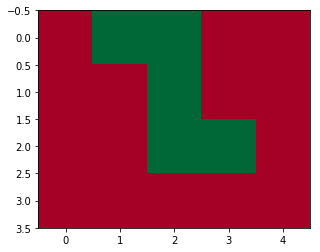

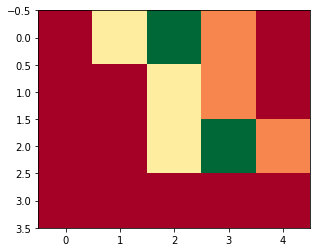

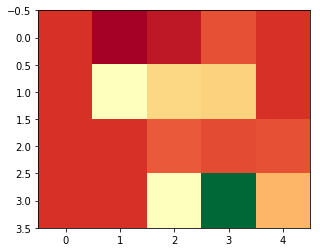

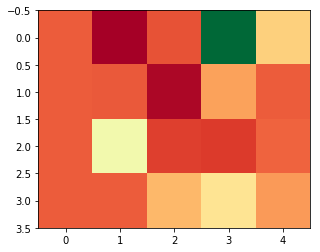

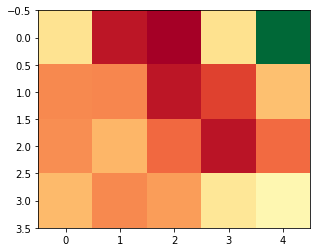

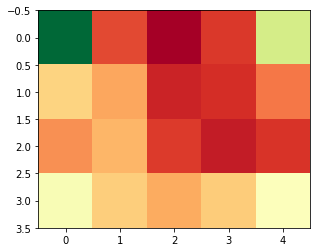

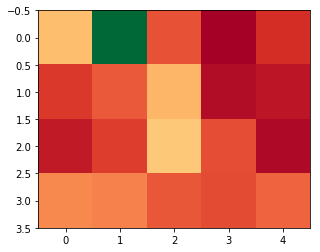

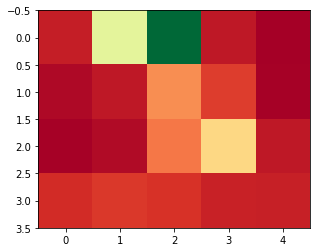

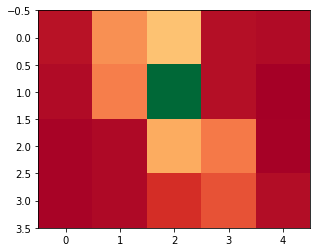

[0.017820167150811587, 0.0853563113831344, 0.11355547435967614, 0.015317773856980365, 0.01306066299670227]
[0.013096282204630959, 0.07759604614334778, 0.32143124633622855, 0.015054874310057538, 0.0047110014509383945]
[0.007402778082077259, 0.012028670283511005, 0.09986305002899779, 0.07420343620044569, 0.007093120974188717]
[0.007993741730562458, 0.011295247883596753, 0.03477565647081586, 0.05497203950756845, 0.01337241864572809]


In [14]:
colors = [['R','G','G','R','R'],
          ['R','R','G','R','R'],
          ['R','R','G','G','R'],
          ['R','R','R','R','R']]
measurements = ['G','G','R','R','R','R','G','G','G']
motions = [[0,0],[0,1],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1],[1,0]]
p = localize(colors,measurements,motions,sensor_right = 0.7, p_move = 0.8)
for i in range(len(p)):
    print(p[i])